# `LynneSim`: A Simple Tool to Investigate Trading LSST Survey Area and Depth

<br>Owner(s): **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/survey_strategy_wp/issues/new?body=@drphilamrshall))
<br>Last Verified to Run: **2018-09-19**

Teams writing white papers may well need to make rough estimates of the cost of various high level decisions that could be taken about the LSST observing strategy, such as how deep to go in various sky regions. `LynneSim` is a simple tool to enable such calculations.

> The "owner" of a notebook is the person you can contact, e.g. by GitHub issue, if the notebook doesn't run. 

### Learning Objectives:

After working through this tutorial you should be able to use `LynneSim` to emulate (very approximately) an OpSim run followed by a (very basic) MAF analysis.

### Logistics
This notebook is intended to be runnable anywhere, with only standard dependencies.

## Set-up

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Getting Started

Suppose we want to know how many visits per field, and hence the 5-sigma depth, we could get, if we put the standard number of visits in the usual WFD region, and then split the remainder over the rest of our "big sky" (-90 to +32 deg) - and don't do any DDFs or mini-surveys at all. One way to answer this question is to ask Lynne Jones to configure and run OpSim, and then do a MAF analysis. We can get an approximate answer with a very simple emulator of Lynne Jones.

In [2]:
class LynneSim(object):
    """
    Worker class for estimating approximate LSST depth etc in a mock proposal-based LSST survey campaign.
    """
    def __init__(self):
        # Set some constants:
        self.totalNvis = 2600000  # without snaps (1x30s/visit)
        # Let's say we can play with 90% of these visits:
        self.percentTotal = 0.90
        self.Nvisits = self.totalNvis * self.percentTotal
        print("The number of visits available is %d (%.2fM)" % (self.Nvisits, self.Nvisits/1000000))
        self.filters = ['u','g','r','i','z','y']
        # Read in available fields
        self.fields = pd.read_csv('field_list.csv')
        # Prepare to define survey regions
        self.regions = {}
        self.NvisitsPerField = {}
        self.fractions = {}
        self.filter_visits = {}
        self.filter_depths = {}

        return
    
    def define_survey_region(self, name, limits=None, NvisitsPerField=None, fractions=None):
        """
        Extract a subset of the fields, within the given spatial limits.
        
        Parameters
        ==========
        name: string
            The name of the survey region being specified
        limits: dict
            Limits in ra/dec, galactic b/l and/or ecliptic b/l that define the survey region
        """
        if limits is None:
            limits = {'ra':[0.0,360.0], 'dec':[-90,90], 'gl':[0.0,360.0], 'gb':[-90.0,90.0], 'el':[0.0,360.0], 'eb':[-90.0,90.0]}
        if fractions is None:
            onesixth = 1.0/6.0
            self.fractions[name] = {'u':onesixth, 'g':onesixth, 'r':onesixth, 'i':onesixth, 'z':onesixth, 'y':onesixth}
        self.NvisitsPerField[name] = NvisitsPerField
        
        subset = self.fields
        for coord in limits.keys():
            xmin, xmax = limits[coord][0], limits[coord][1]
            if xmax > xmin: 
                plus = 'and'
            else:
                plus = 'or'
            in_this_range = "({x} >= {xmin}) {and_or} ({x} <= {xmax})".format(x=coord, xmin=xmin, and_or=plus, xmax=xmax)
            subset = subset.query(in_this_range)
        self.regions[name] = subset
        
        print("The number of fields in the {0} footprint is {1:d}".format(name, len(subset)))

        return
        
    def distribute_visits(self):
        """
        Compute Nvis per field in each survey region.
        """
        # Loop over defined regions, computing number of visits, and depth, in each field.
        count = 0
        the_rest = []
        fields_remaining = 0
        for name in self.regions.keys():
            Nfields = len(self.regions[name])
            if self.NvisitsPerField[name] is not None:
                self.regions[name] = add_constant_column(self.regions[name], 'Nvis', self.NvisitsPerField[name])
                this_many = int(round(np.sum(self.regions[name].Nvis)))
                print(this_many," visits allocated to region ", name)
                print(self.NvisitsPerField[name]," visits per ",name," field")
                count += this_many
            else:
                the_rest.append(name)
                fields_remaining += Nfields        
        remainder = int(self.Nvisits - count)
        print("Distributing ",remainder," visits among the remaining regions: ",the_rest)
        
        thisManyVisitsPerField = int(remainder / fields_remaining)
        for name in the_rest:
            Nfields = len(self.regions[name])
            self.NvisitsPerField[name] = thisManyVisitsPerField
            self.regions[name] = add_constant_column(self.regions[name], 'Nvis', self.NvisitsPerField[name])
            this_many = int(round(np.sum(self.regions[name].Nvis)))
            print(this_many," visits allocated to region ", name)
            print(self.NvisitsPerField[name]," visits per ",name," field")
        
        # All fields in all regions now have an Nvis value - the total number of visits after 10 years.
        # Now distribute those visits among the filters, using each region's fractions.
        for name in self.regions.keys():
            # Make a visit number dictionary based on the filter fractions:
            filters = list(self.fractions[name].keys())
            values = [int(round(frac*self.NvisitsPerField[name])) for filter,frac in self.fractions[name].items()]
            filter_visits = dict(zip(filters, values))
            # For each filter, add a column:
            for filter in filters:
                column = 'Nvis_'+filter
                value = filter_visits[filter]
                self.regions[name] = add_constant_column(self.regions[name], column, value)
            self.filter_visits[name] = filter_visits

        # All regions now have 6 new columns, the number of visits in each filter.
        # Because of the rounding, it's unlikely that Nvis will equal the sum of Nvis_*. Don't worry about it.
        
        return

    def calculate_metrics(self):
        """
        Compute depth per field, per filter.
        
        Notes
        =====
        Currently we assume non-overlapping regions...
        """
        # Loop over regions
        for name in self.regions.keys():
            filters = list(self.fractions[name].keys())
            values = [calculate_depth(N,filter) for filter,N in self.filter_visits[name].items()]
            filter_depth = dict(zip(filters, values))
            for filter in filters:
                k = 'Nvis_'+filter
                column = 'depth_'+filter
                value = filter_depth[filter]
                self.regions[name] = add_constant_column(self.regions[name], column, value)
            
            
        return

    def plot_sky_map(self, metric=None):
        """
        Plot the desired metric as a sky map.
        
        Parameters
        ==========
        metric: string
            Name of the metric to be plotted [Nvis, depth]
        """
        if metric is None: 
            pass # Just plot locations, no grayscale for metric.
        
        fig = plt.figure(figsize=(8, 8))
        ax = plt.subplot(111, projection="aitoff")
        for name in self.regions.keys():
            x, y = radec2project(self.regions[name].ra, self.regions[name].dec)
            if metric is None:
                ax.scatter(x, y, alpha=0.7, label=name) # Marker color is assigned automatically
            else:
                if metric == 'Nvis':
                    z = self.regions[name].Nvis
                # Need to add Nvis per filter as possible metrics.
                else:
                    try: 
                        z = self.regions[name][metric]
                    except:
                        raise ValueError("unrecognized metric {}".format(metric))
                s = ax.scatter(x, y, c=z, cmap='viridis')
                # s.set_clim([0,1000])
        plt.grid(True)
        if metric is None: 
            plt.legend()
        else:
            plt.colorbar(s, orientation='horizontal')
        return


def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

def add_constant_column(df, column, value):
    """
    Append a new column of floating point numbers to a dataframe, consisting of the same value, repeated.
    
    Parameters
    ==========
    df: pandas dataframe
        Table to add a new column to
    column: string
        The name of the new column
    value: float
        The value to populate the column with
    """
    length = len(df)
    new_column = pd.DataFrame({column: np.ones(length)*value})
    df = df.join(new_column)
    return df

def calculate_depth(N, f):
    """
    Given number of visits in a particular filter, compute the 5-sigma limiting magnitude.
    
    Parameters
    ==========
    N: int
        Number of visits
    f: string
        Name of filter [u,g,r,i,z,y]
    """
    # Current expected performance for single visit 5-sigma depth:
    single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}
    # Scheduler inefficiency varies with band. Calibrated to kraken_2026:
    efficiency_correction = {'u': 0.39, 'g': 0.10, 'r': 0.04, 'i': 0.19, 'z': 0.46, 'y': 0.38}
    return single_m5[f] + 2.5 * np.log10(N) - efficiency_correction[f]


In [3]:
Lynne = LynneSim()

The number of visits available is 2340000 (2.34M)


In [4]:
Lynne.fields[0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb
0,1,3.5,0.000000,-90.000000,-57.068082,-27.128251,-89.931210,-66.561358
1,2,3.5,180.000000,-87.568555,-57.663825,-24.756541,-96.024547,-66.442665
2,3,3.5,324.000429,-87.568550,-54.980423,-28.712449,-85.262622,-65.058907
3,4,3.5,35.999571,-87.568550,-58.164147,-29.359810,-84.695237,-67.907706
4,5,3.5,252.001105,-87.568547,-54.748581,-25.862125,-91.659618,-64.238559


In [5]:
Lynne.define_survey_region('WFD', NvisitsPerField=825, limits={'dec':[-72.25,12.4], 'gb':[15.0,-15.0]})
Lynne.define_survey_region('GalacticPlane', limits={'gb':[-15.0,15.0], 'gl':[-180.0,180.0], 'dec':[-90.0,12.4]})

The number of fields in the WFD footprint is 2290
The number of fields in the GalacticPlane footprint is 798


In [6]:
Lynne.distribute_visits()

1282875  visits allocated to region  WFD
825  visits per  WFD  field
Distributing  1057125  visits among the remaining regions:  ['GalacticPlane']
368072  visits allocated to region  GalacticPlane
1324  visits per  GalacticPlane  field


In [7]:
Lynne.calculate_metrics()

In [8]:
Lynne.regions['GalacticPlane'][0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb,Nvis,Nvis_u,...,Nvis_r,Nvis_i,Nvis_z,Nvis_y,depth_u,depth_g,depth_r,depth_i,depth_z,depth_y
67,68,3.5,193.206897,-77.535325,-56.990572,-14.663785,-115.784993,-61.192813,1324.0,221.0,...,221.0,221.0,221.0,221.0,29.450981,30.670981,30.240981,29.640981,28.780981,27.950981
71,72,3.5,180.000000,-76.461360,-60.144794,-13.897841,-121.120283,-63.124626,1324.0,221.0,...,221.0,221.0,221.0,221.0,29.450981,30.670981,30.240981,29.640981,28.780981,27.950981
76,77,3.5,215.999990,-75.741972,-51.345487,-13.908912,-110.958446,-56.267797,1324.0,221.0,...,221.0,221.0,221.0,221.0,29.450981,30.670981,30.240981,29.640981,28.780981,27.950981
81,82,3.5,203.037810,-75.516238,-54.469851,-12.850270,-115.787081,-58.146028,1324.0,221.0,...,221.0,221.0,221.0,221.0,29.450981,30.670981,30.240981,29.640981,28.780981,27.950981
91,92,3.5,190.840031,-74.831653,-57.608121,-11.968375,-120.851045,-59.991241,1324.0,221.0,...,221.0,221.0,221.0,221.0,29.450981,30.670981,30.240981,29.640981,28.780981,27.950981


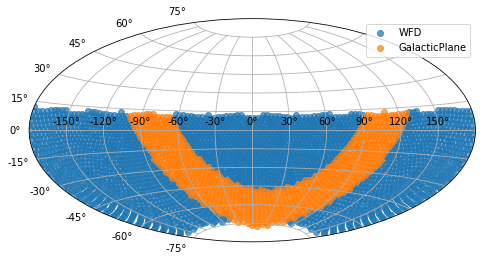

In [9]:
Lynne.plot_sky_map()

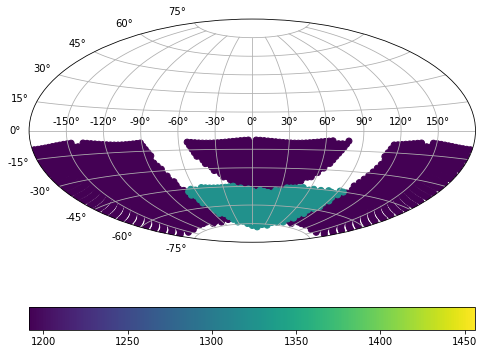

In [10]:
Lynne.plot_sky_map(metric='Nvis')

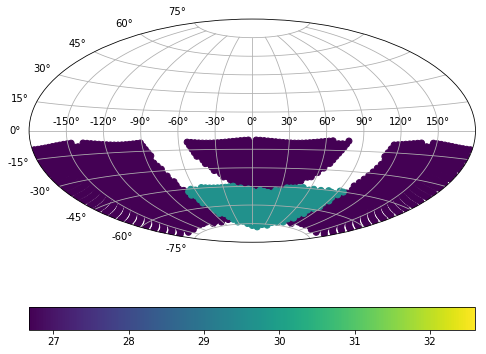

In [11]:
Lynne.plot_sky_map(metric='depth_i')

## Further Work

It's not clear yet how useful the `LynneSim` abstraction will be: the area/depth tradeoff notebooks are better for understanding what is being calculated, because of their sequential nature. But, for carrying out a suite of (more than one or two) cheap experiments, it's going to be better to summon a `LynneSim` worker.

So far, the only metrics implemented are the depths by filter - there could be others that could be plausibly emulated. At some point we might want to abstract a metric object to enable easier implementation of additional metrics. Likewise, the survey regions may need a more careful treatment - at the moment overlapping fields are not treated well at all. 